##### Copyright 2020 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License").
<!--
    Licensed to the Apache Software Foundation (ASF) under one
    or more contributor license agreements.  See the NOTICE file
    distributed with this work for additional information
    regarding copyright ownership.  The ASF licenses this file
    to you under the Apache License, Version 2.0 (the
    "License"); you may not use this file except in compliance
    with the License.  You may obtain a copy of the License at

      http://www.apache.org/licenses/LICENSE-2.0

    Unless required by applicable law or agreed to in writing,
    software distributed under the License is distributed on an
    "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
    KIND, either express or implied.  See the License for the
    specific language governing permissions and limitations
    under the License.
-->


# Analyzing AI Platform Prediction Request Response Log using TensorFlow Data Validation

In [39]:
import json
import os

import pandas as pd
import seaborn
import tensorflow_data_validation as tfdv
import tensorflow as tf

from datetime import datetime
from google.cloud import bigquery
from jinja2 import Template
from tensorflow_metadata.proto.v0 import statistics_pb2
from tensorflow_data_validation.utils.stats_util import get_feature_stats
from tensorflow_data_validation import FeaturePath

## Configure environment settings

In [1]:
project_id = 'mlops-dev-env'
response_request_log_table = 'data_validation.covertype_classifier_logs_tf'

## Retrieve records from AI Platform Prediction Request Response log

### Prepare a query

In [10]:
def generate_query(table_name, start_time, end_time):

  sampling_query_template = """
       SELECT *
       FROM 
           `{{ source_table }}`
       WHERE time BETWEEN '{{ start_time }}' AND '{{ end_time }}'
       """
  
  query = Template(sampling_query_template).render(
      source_table=table_name, start_time=start_time, end_time=end_time)

  return query


### Run a query

In [81]:
start_time = '2020-05-15T00:00:00'
end_time = '2020-05-19T00:00:00'

query = generate_query(response_request_log_table, start_time, end_time)

client = bigquery.Client()
query_job = client.query(query)
rows = query_job.result()

### Convert the `raw_data` column into a pandas dataframe

In [82]:
instances = []
for row in rows:
    raw_data = json.loads(row['raw_data'])
    for instance in raw_data['instances']:
        instances.append({column_name: value[0] 
            for column_name, value in instance.items()})

df = pd.DataFrame(instances)
df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Soil_Type
0,2885,250,27,60,28,2624,153,247,225,972,Commanche,4758
1,2909,315,26,150,75,5465,141,208,202,4830,Rawah,7700
2,2717,69,23,153,68,1265,237,187,69,904,Commanche,4758
3,2652,61,12,376,24,400,230,215,117,1812,Rawah,4744
4,3189,351,16,365,83,1065,191,212,158,2056,Commanche,7201
...,...,...,...,...,...,...,...,...,...,...,...,...
17233,3132,93,17,424,-16,6030,245,212,90,1310,Rawah,7745
17234,3007,55,34,335,95,2038,219,149,37,1812,Commanche,7757
17235,2532,214,14,285,104,541,205,253,181,216,Cache,2717
17236,2744,53,9,255,79,2697,226,220,128,1140,Commanche,2703


In [87]:
stats = tfdv.generate_statistics_from_dataframe(
    dataframe=df
)

In [88]:
tfdv.visualize_statistics(stats)

In [43]:
raw_data_dict = json.loads(raw_data[0])
feature_dict = raw_data_dict['instances'][0]
columns

dict_keys(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Soil_Type'])

In [21]:
for row in df.iterrows():
    

,model,model_version,time,raw_data,raw_prediction,groundtruth
0,covertype_classifier_tf,v2,2020-05-15 00:15:00+00:00,"{""instances"": [{""Elevation"": [2814], ""Aspect"":...","{\n ""predictions"": [[0.467300355, 0.5288516...",None
1,covertype_classifier_tf,v2,2020-05-15 00:16:00+00:00,"{""instances"": [{""Elevation"": [3305], ""Aspect"":...","{\n ""predictions"": [[0.0720900595, 3.621145...",None
2,covertype_classifier_tf,v2,2020-05-15 00:17:00+00:00,"{""instances"": [{""Elevation"": [3175], ""Aspect"":...","{\n ""predictions"": [[0.995114565, 0.0048643...",None
3,covertype_classifier_tf,v2,2020-05-15 00:18:00+00:00,"{""instances"": [{""Elevation"": [3195], ""Aspect"":...","{\n ""predictions"": [[0.795716882, 0.2021486...",None
4,covertype_classifier_tf,v2,2020-05-15 00:19:00+00:00,"{""instances"": [{""Elevation"": [2782], ""Aspect"":...","{\n ""predictions"": [[0.008903821, 0.4464142...",None
...,...,...,...,...,...,...
5741,covertype_classifier_tf,v2,2020-05-16 23:55:00+00:00,"{""instances"": [{""Elevation"": [2912], ""Aspect"":...","{\n ""predictions"": [[0.398688287, 0.6005383...",None
5742,covertype_classifier_tf,v2,2020-05-16 23:56:00+00:00,"{""instances"": [{""Elevation"": [2925], ""Aspect"":...","{\n ""predictions"": [[0.481690377, 0.4850754...",None
5743,covertype_classifier_tf,v2,2020-05-16 23:57:00+00:00,"{""instances"": [{""Elevation"": [3257], ""Aspect"":...","{\n ""predictions"": [[0.38911131, 0.00070537...",None
5744,covertype_classifier_tf,v2,2020-05-16 23:58:00+00:00,"{""instances"": [{""Elevation"": [3054], ""Aspect"":...","{\n ""predictions"": [[0.803099036, 0.1966052...",None


In [59]:
statistics_proto_list = statistics_pb2.DatasetFeatureStatisticsList()
for folder in tf.io.gfile.listdir(drift_reports_path):
    statistics_proto = tfdv.load_statistics(
        '{}/{}{}'.format(drift_reports_path, folder, 'stats.pb'))
    new_stats_proto = statistics_proto_list.datasets.add()
    new_stats_proto.CopyFrom(statistics_proto.datasets[0])
    new_stats_proto.name = folder[:-1]

tfdv.write_stats_text(statistics_proto_list, aggregated_statistics_path)

In [111]:
class StatsSeries():
    def __init__(self, stats_proto_list):
        self._stats_proto_list = stats_proto_list

    def get_feature_means(self, feature_index):
        list_of_means = {
             dataset.name[0:16]: dataset.features[feature_index].num_stats.mean
             for dataset in self._stats_proto_list.datasets}
        
        return list_of_means


In [112]:
aggregated_statistics = tfdv.load_stats_text(aggregated_statistics_path)
stats_series = StatsSeries(aggregated_statistics)

In [115]:
feature_mean_series = stats_series.get_feature_means(0)
feature_mean_series.keys()

dict_keys(['2020-05-18T19:07', '2020-05-18T20:07', '2020-05-18T21:07', '2020-05-18T22:07', '2020-05-18T23:07', '2020-05-19T00:07', '2020-05-19T01:07', '2020-05-19T02:07', '2020-05-19T05:07', '2020-05-19T06:07', '2020-05-19T07:07', '2020-05-19T08:07', '2020-05-19T09:07', '2020-05-19T10:07', '2020-05-19T11:07', '2020-05-19T12:07', '2020-05-19T13:07', '2020-05-19T14:07', '2020-05-19T15:07'])

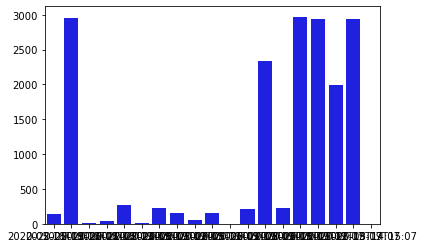

In [116]:
seaborn.barplot(x=list(feature_mean_series.keys()), y=list(feature_mean_series.values()), color='blue')

In [2]:
OUTPUT_PATH = 'gs://mlops-dev-workspace/drift_monitor/output/tf'
 
_STATS_FILENAME='stats.pb'
_ANOMALIES_FILENAME='anomalies.pbtxt'

stats_output_path = os.path.join(OUTPUT_PATH, _STATS_FILENAME)
anomalies_output_path = os.path.join(OUTPUT_PATH, _ANOMALIES_FILENAME)

In [3]:
stats = tfdv.load_statistics(stats_output_path)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [4]:
tfdv.visualize_statistics(stats)

In [5]:
anomalies = tfdv.load_anomalies_text(anomalies_output_path)

In [6]:
tfdv.display_anomalies(anomalies)

,Anomaly short description,Anomaly long description
Feature name,,
'Soil_Type',Unexpected string values,"Examples contain values missing from the schema: 2702 (<1%), 2703 (~1%), 2704 (<1%), 2705 (~2%), 2706 (<1%), 2717 (~1%), 4201 (<1%), 4703 (~6%), 4704 (~2%), 4744 (~4%), 4758 (~2%), 5101 (<1%), 6101 (<1%), 6102 (<1%), 6731 (<1%), 7101 (<1%), 7102 (<1%), 7103 (<1%), 7201 (~5%), 7202 (~9%), 7700 (~2%), 7701 (<1%), 7702 (<1%), 7710 (<1%), 7745 (~22%), 7746 (~4%), 7755 (~4%), 7756 (~9%), 7757 (~7%), 7790 (<1%), 8703 (<1%), 8707 (<1%), 8771 (~3%), 8772 (~1%), 8776 (~1%)."
'Cover_Type',Column dropped,Column is completely missing
